# 02. Preprocessing and Feature Engineering

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Load cleaned data from previous notebook
print("Loading cleaned data...")
train_cleaned = pd.read_csv('../data/train_cleaned.csv')
test_cleaned = pd.read_csv('../data/test_cleaned.csv')
test_ID = test_cleaned['id']

Loading cleaned data...


In [4]:
train_cleaned.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,70.0,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,NaN,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


## 1. Feature Engineering

In [5]:
def engineer_features(df):
    """Process and engineer the most important features"""
    result = df.copy()
    
    # Log transformation of important area variables
    result['log_gr_liv_area'] = np.log1p(result['gr_liv_area'])
    result['log_lot_area'] = np.log1p(result['lot_area'])
    
    # Total square footage
    result['total_sf'] = result['total_bsmt_sf'] + result['1st_flr_sf'] + result['2nd_flr_sf']
    result['log_total_sf'] = np.log1p(result['total_sf'])
    
    # Age features
    result['house_age'] = result['yr_sold'] - result['year_built']
    result['remod_age'] = result['yr_sold'] - result['year_remod/add']
    result['recent_reno'] = (result['yr_sold'] - result['year_remod/add'] <= 2).astype(int)
    
    # Quality features
    result['overall_qual2'] = result['overall_qual']**2
    result['qual_cond'] = result['overall_qual'] * result['overall_cond']
    
    # Interaction between area and quality
    result['living_area_qual'] = result['gr_liv_area'] * result['overall_qual']
    
    # Total bathrooms
    result['total_bathrooms'] = (
        result['full_bath'] + 
        result['half_bath']*0.5 + 
        result['bsmt_full_bath'] + 
        result['bsmt_half_bath']*0.5
    )
    
    # Bath to bed ratio with protection against zero
    result['bath_per_bed'] = result['total_bathrooms'] / (result['bedroom_abvgr'] + 1)
    
    # Has feature flags
    result['has_fireplace'] = (result['fireplaces'] > 0).astype(int)
    result['has_garage'] = (result['garage_cars'] > 0).astype(int)
    result['has_pool'] = (result['pool_area'] > 0).astype(int)
    result['has_porch'] = (result['open_porch_sf'] > 0).astype(int)
    
    # Total porch area
    result['total_porch_sf'] = (
        result['wood_deck_sf'] + 
        result['open_porch_sf'] + 
        result['enclosed_porch'] + 
        result['3ssn_porch'] + 
        result['screen_porch']
    )
    
    # Ordinal features - convert to numeric
    qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
    
    # Convert quality fields to numeric
    for col in ['exter_qual', 'kitchen_qual', 'bsmt_qual', 'fireplace_qu', 'garage_qual']:
        if col in result.columns:
            new_col = col.replace(' ', '') + '_num'
            result[new_col] = result[col].map(qual_map)
            # Fill any missing values with the median
            if result[new_col].isna().any():
                result[new_col] = result[new_col].fillna(result[new_col].median())
    
    # Finished basement percentage
    safe_division = lambda n, d: n / d if d > 0 else 0
    result['finished_bsmt_pct'] = result.apply(
        lambda x: safe_division(x['bsmtfin_sf_1'] + x['bsmtfin_sf_2'], x['total_bsmt_sf']), 
        axis=1
    )
    
    # Central Air
    if 'central_air' in result.columns:
        result['central_air_num'] = (result['central_air'] == 'Y').astype(int)
    
    return result

# Applying feature engineering
train_processed = engineer_features(train_cleaned)
test_processed = engineer_features(test_cleaned)

In [6]:
# 3. Create neighborhood price level feature (only using training data)
neighborhood_price = train_processed.groupby('neighborhood')['saleprice'].median()
train_processed['neighborhood_price_level'] = train_processed['neighborhood'].map(neighborhood_price)

# For test data, map the same neighborhood values from training
test_processed['neighborhood_price_level'] = test_processed['neighborhood'].map(neighborhood_price)

### 1.1 Ground Living Area and Lot Area

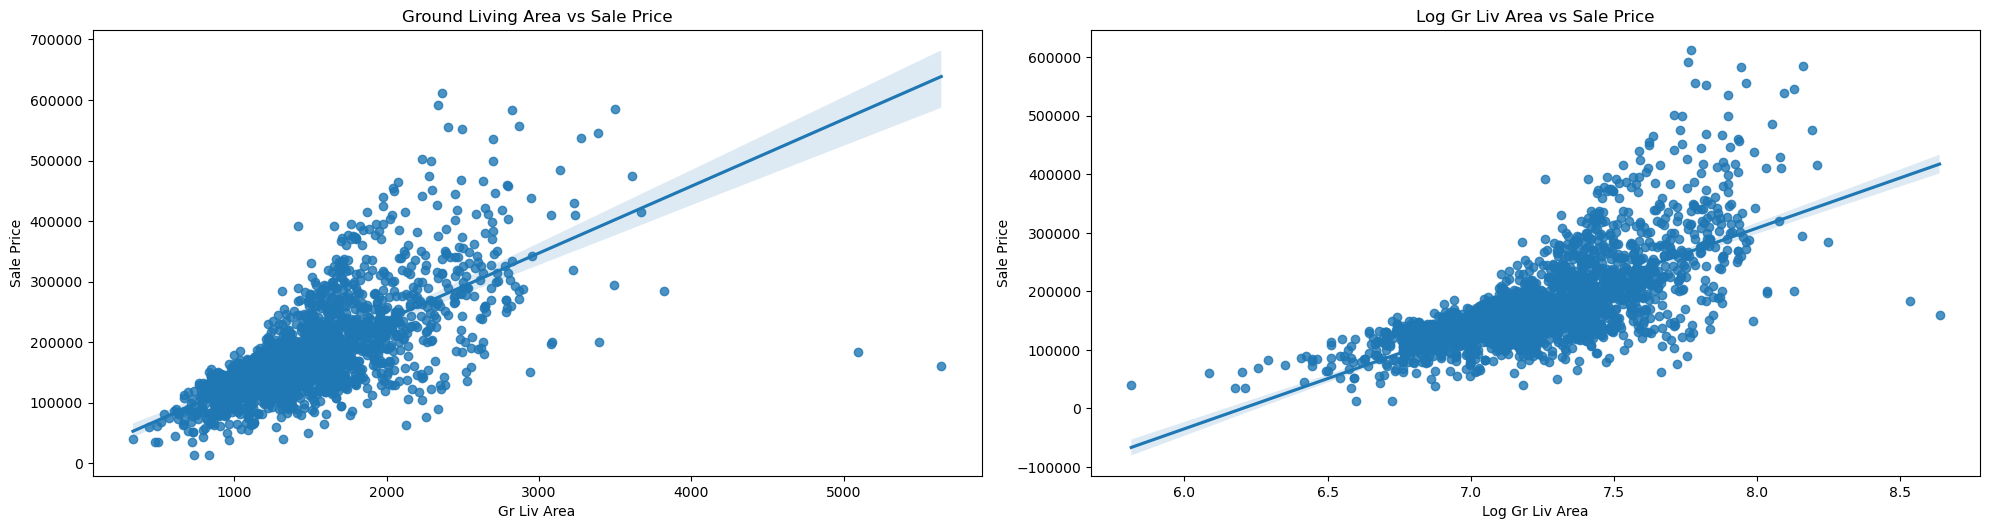

In [7]:
# Visualize relationship between log-transformed features and price
plt.figure(figsize=(20, 10))

plt.subplot(2,2,1)
sns.regplot(x='gr_liv_area', y='saleprice', data=train_processed)
plt.title('Ground Living Area vs Sale Price')
plt.xlabel('Gr Liv Area')
plt.ylabel('Sale Price')

plt.subplot(2,2,2)
sns.regplot(x='log_gr_liv_area', y='saleprice', data=train_processed)
plt.title('Log Gr Liv Area vs Sale Price')
plt.xlabel('Log Gr Liv Area')
plt.ylabel('Sale Price')

plt.tight_layout()
plt.show()

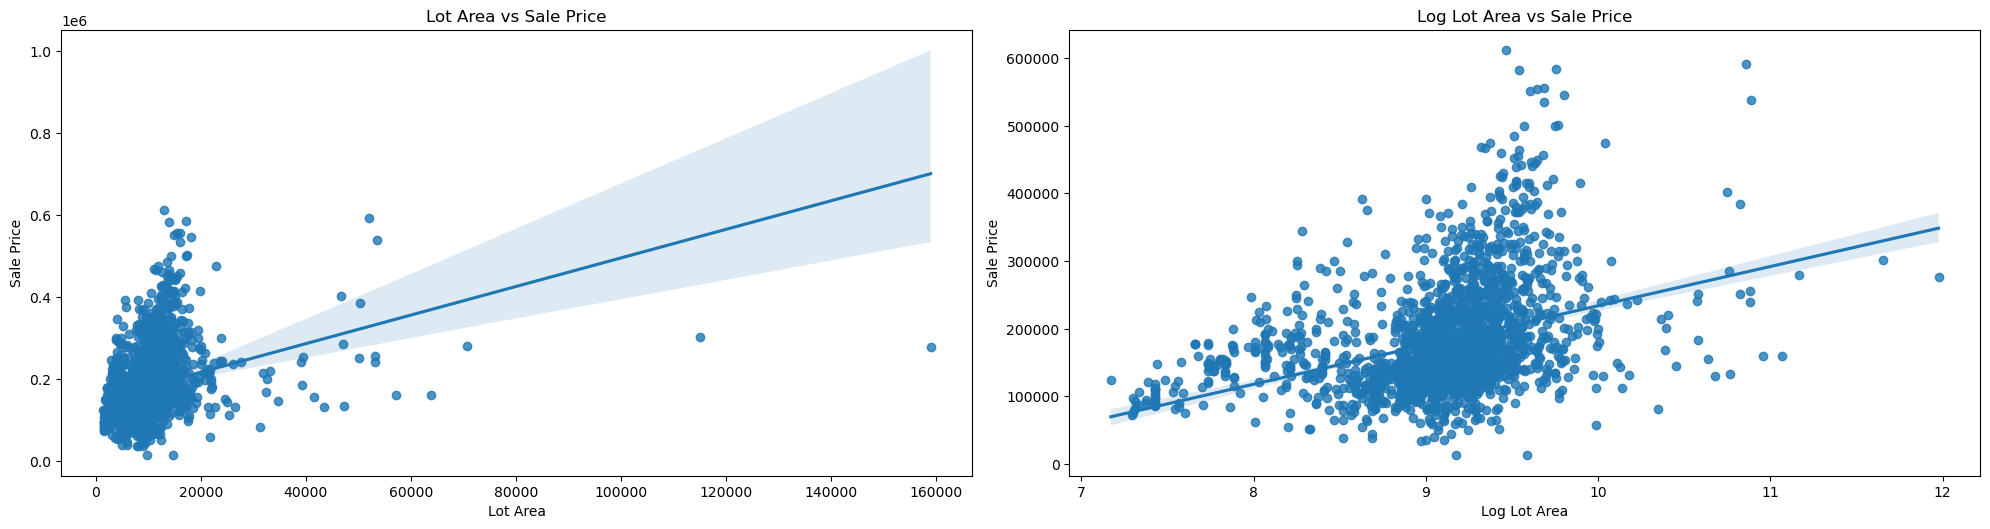

In [8]:
# Visualize relationship between log-transformed features and price
plt.figure(figsize=(20, 10))

plt.subplot(2,2,1)
sns.regplot(x='lot_area', y='saleprice', data=train_processed)
plt.title('Lot Area vs Sale Price')
plt.xlabel('Lot Area')
plt.ylabel('Sale Price')

plt.subplot(2,2,2)
sns.regplot(x='log_lot_area', y='saleprice', data=train_processed)
plt.title('Log Lot Area vs Sale Price')
plt.xlabel('Log Lot Area')
plt.ylabel('Sale Price')

plt.tight_layout()
plt.show()

**Note**
- The log transformation addresses the non-linear relationship between area and price. House prices don't increase linearly with size - there are diminishing returns.
- The log transformation linearize this relationship, making it more suitable for linear regression.

- Rather than treating different floor areas separately (which creates multicolinearity), combining them into a total provides a unified measure of house size.
- This reduces VIF (Variance Inflation Factor) while maintaining predicting power. The log transformation again addresses the non-linear relationship with price.

### 1.2 Total Square Footage Features

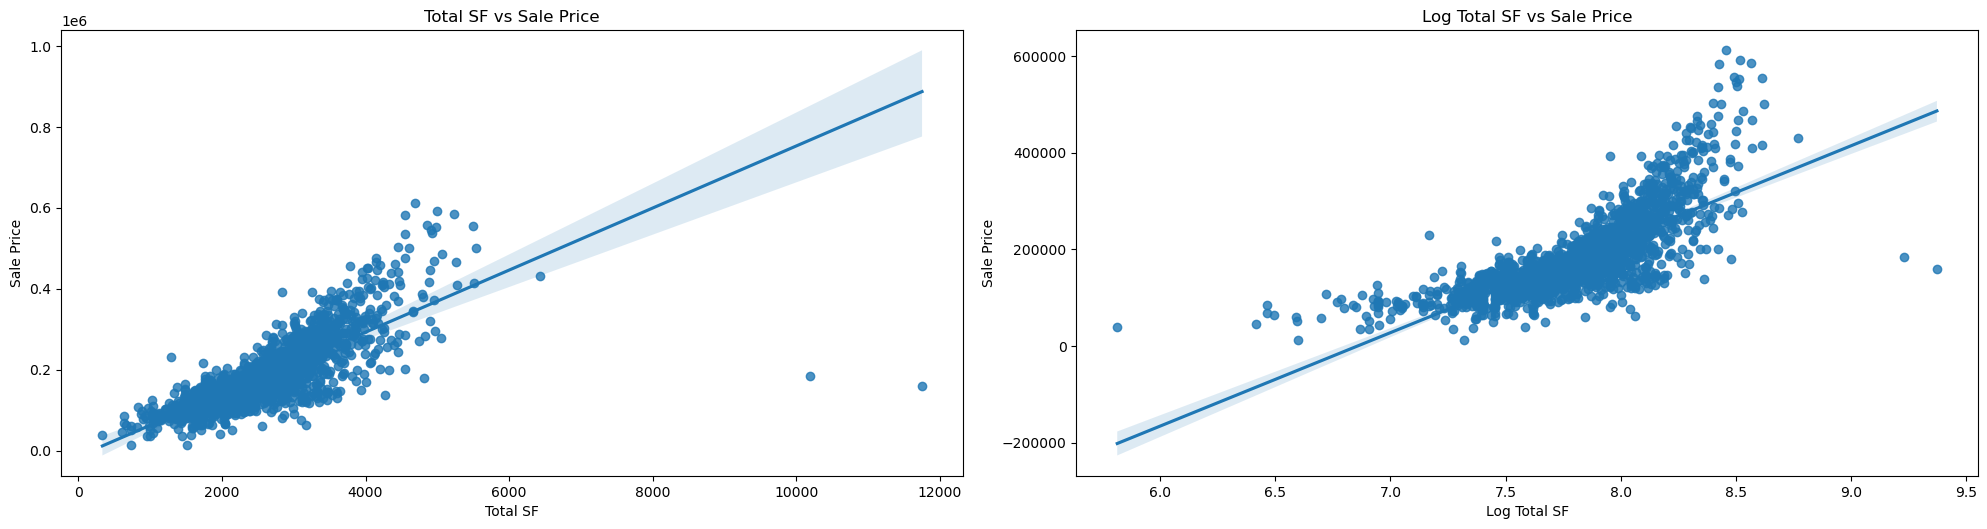

In [9]:
# Visualize relationship between log-transformed features and price
plt.figure(figsize=(20, 10))

plt.subplot(2,2,1)
sns.regplot(x='total_sf', y='saleprice', data=train_processed)
plt.title('Total SF vs Sale Price')
plt.xlabel('Total SF')
plt.ylabel('Sale Price')

plt.subplot(2,2,2)
sns.regplot(x='log_total_sf', y='saleprice', data=train_processed)
plt.title('Log Total SF vs Sale Price')
plt.xlabel('Log Total SF')
plt.ylabel('Sale Price')

plt.tight_layout()
plt.show()

**Note**
- Rather than treating different floor areas separately (which creates multicolinearity), combining them into a total provides a unified measure of house size.
- This reduces VIF (Variance Inflation Factor) while maintaining predictive power.
- The log transformation again addresses the non-linear relationship with price

### 1.3 Age related features

**HouseAge** = Year Sold - Year Built

**RemodAge** = Year Sold - Year Remodelation/Addition

**RecentReno** = Yearr Sold - Year Remodelation/Addition <= 2

- Raw year values aren't as meaningful as relative ages. Converting to 'age at time of sale' makes more sense as a predictor.
- Houses typically depreciate with age, but recent renovation can counteract this, which is why we track both house age and time since remodeling.

### 1.4 Quality Features and Interactions

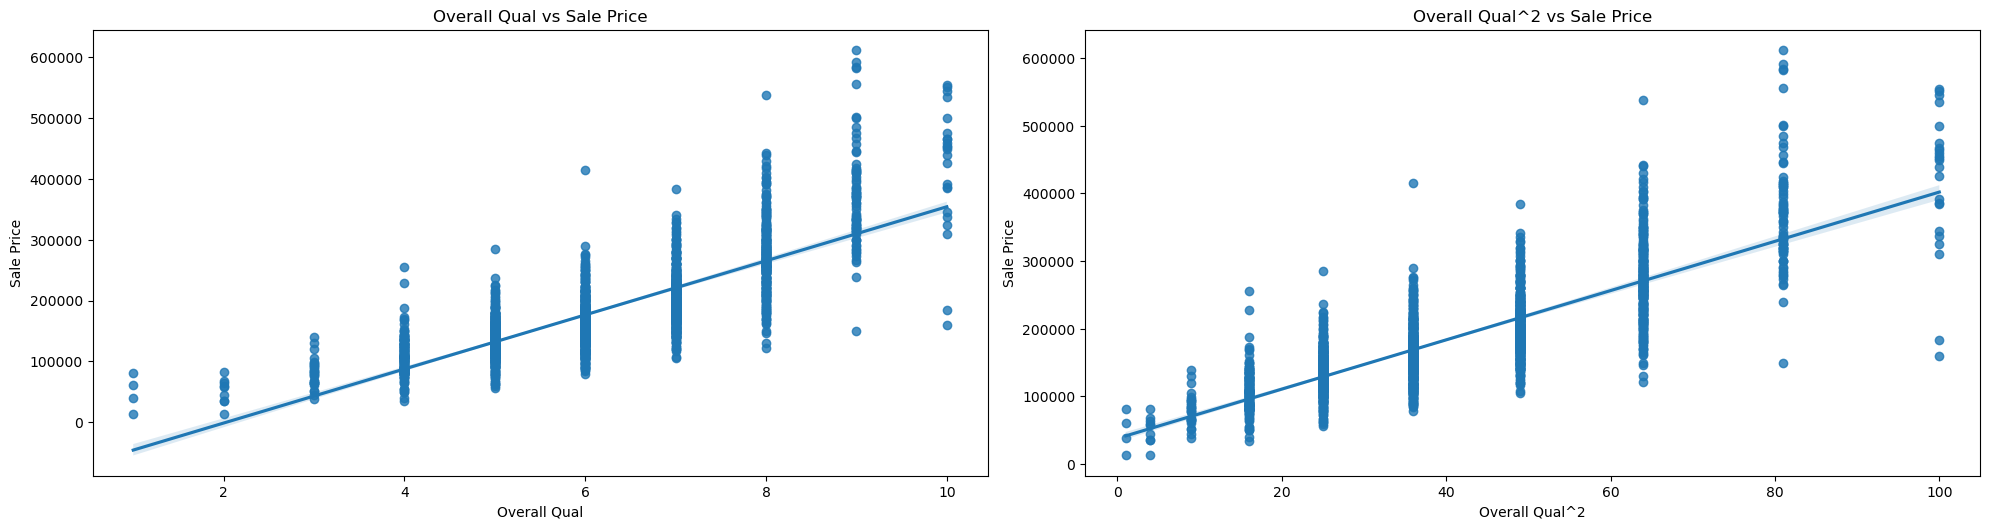

In [10]:
# Visualize relationship between log-transformed features and price
plt.figure(figsize=(20, 10))

plt.subplot(2,2,1)
sns.regplot(x='overall_qual', y='saleprice', data=train_processed)
plt.title('Overall Qual vs Sale Price')
plt.xlabel('Overall Qual')
plt.ylabel('Sale Price')

plt.subplot(2,2,2)
sns.regplot(x='overall_qual2', y='saleprice', data=train_processed)
plt.title('Overall Qual^2 vs Sale Price')
plt.xlabel('Overall Qual^2')
plt.ylabel('Sale Price')

plt.tight_layout()
plt.show()

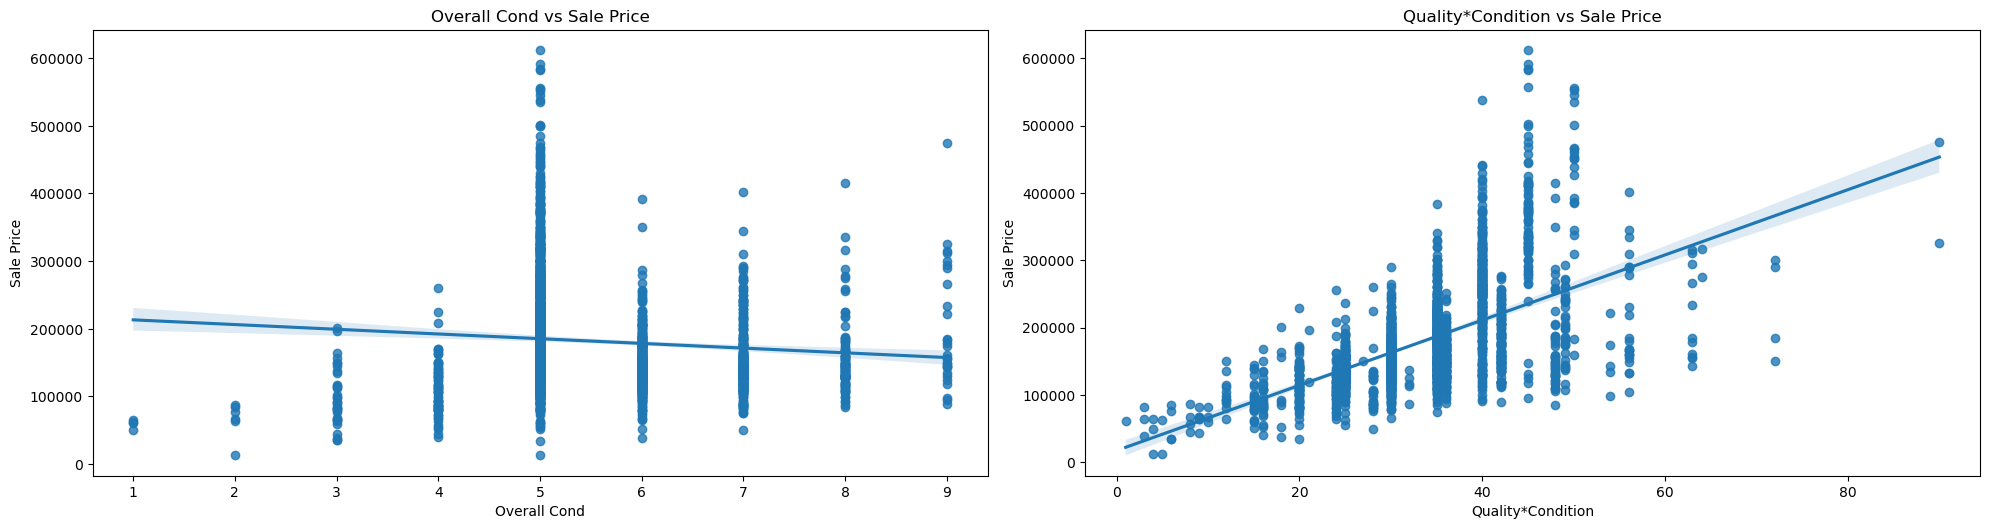

In [11]:
# Visualize relationship between log-transformed features and price
plt.figure(figsize=(20, 10))

plt.subplot(2,2,1)
sns.regplot(x='overall_cond', y='saleprice', data=train_processed)
plt.title('Overall Cond vs Sale Price')
plt.xlabel('Overall Cond')
plt.ylabel('Sale Price')

plt.subplot(2,2,2)
sns.regplot(x='qual_cond', y='saleprice', data=train_processed)
plt.title('Quality*Condition vs Sale Price')
plt.xlabel('Quality*Condition')
plt.ylabel('Sale Price')

plt.tight_layout()
plt.show()

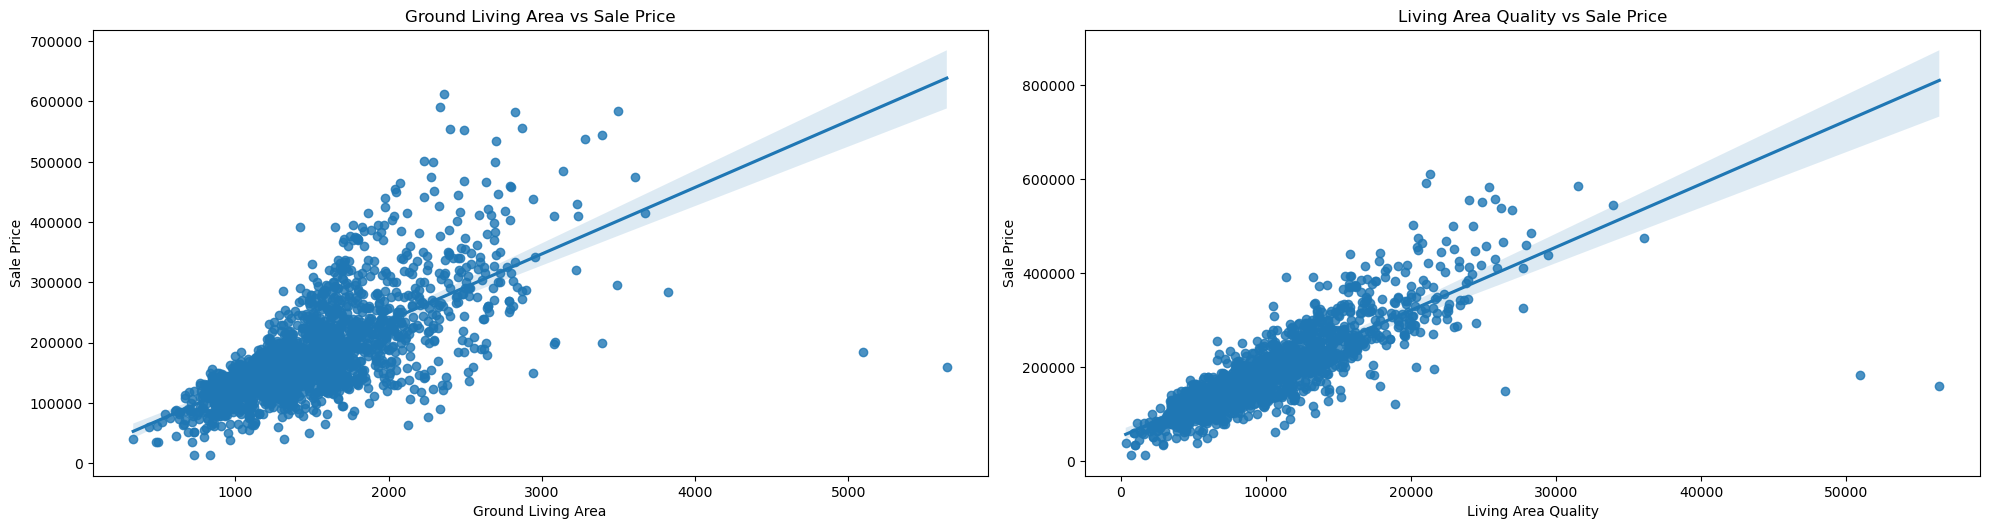

In [12]:
# Visualize relationship between log-transformed features and price
plt.figure(figsize=(20, 10))

plt.subplot(2,2,1)
sns.regplot(x='gr_liv_area', y='saleprice', data=train_processed)
plt.title('Ground Living Area vs Sale Price')
plt.xlabel('Ground Living Area')
plt.ylabel('Sale Price')

plt.subplot(2,2,2)
sns.regplot(x='living_area_qual', y='saleprice', data=train_processed)
plt.title('Living Area Quality vs Sale Price')
plt.xlabel('Living Area Quality')
plt.ylabel('Sale Price')

plt.tight_layout()
plt.show()

**Note**
- The EDA showed that Overall Quality has a non-linear relationship wiht price - high quality homes command an exponential premium (hence the squared term).
- The interaction terms capture important relationships: high quality combined with large size yields premium prices beyond what either feature alone would predict.

### 1.5 Bathroom Features

**Total Bathrooms** = Full Bath + Half Bath x 0.5 + Bsmt Full Bath + Bsmt Half Bath x 0.5

**Bath to bed ratio** = TotalBathrooms /( Bedroom Above Ground + 1)

**Note**
- Combining all bathroom counts provides a more comprehensive measure and reduces multicolinearity.
- The bath-to-bed ratio captures an importan relationship: houses wiht more bathrooms per bedroom tend to be more luxurious and command higher prices.

### 1.6 Binary Has Feature Indicators

**Has Fireplace** = Fireplaces > 0

**Has Garage** = Garage Cars > 0

**Has Pool** = Pool Area > 0

**Note**
- The presence/absence of key amenities often has a stronger relationship with price than the raw measurements.
- There's a jump in price for having a feature versus not having it, then a more gradual increase as the feature gets bigger/better.

### 1.7 Porch Area Combination

**Total porch area** = Wood Deck SF + Open Porch SF + Enclosed Porch + 3Ssn Porch + Screen Porch

**Note**
- Combining similar features simplifies the model and reduces multicolinearity.
- Different porch types are somwhat substitutable, and the total outdoor living space is more important than the specific type.

### 1.8 Converting Ordinal Features to Numeric

**Quality Map** = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}

- **Exterior Quality**
- **Kitchen Quality**
- **Basement Quality**
- **Fireplace Quality**
- **Garage Quality**

**Note**
- Converting ordinal categories to numbers allows them to be used in a regression model.
- The numeric values preserve the ordering of the categories and create a more inerpretable scale.

### 1.9 Neighborhood Price Level

**Neighborhood Price** = Median of the Sale Price grouped by Neighborhood

**Neighborhood Price Level** = Mapping Neighborhood to Neighborhood_Price

**Note**
- This way we can encode neighborhood value.
- Rather than using many dummy variables, we capture the price effect of neighborhood in a single continuous variable.
- This dramatically reduces dimensionality while preserving the most important information.

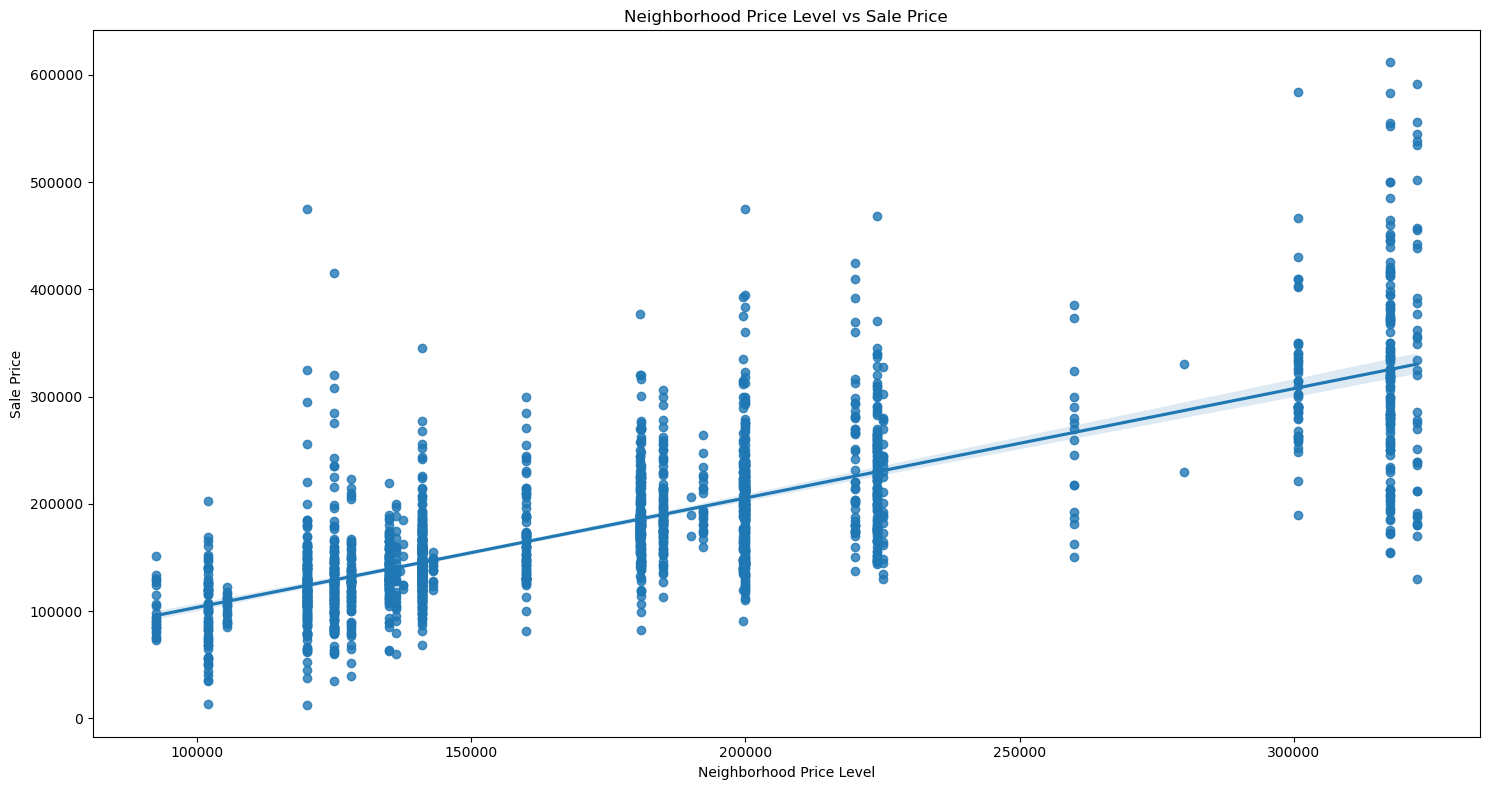

In [13]:
# Visualize relationship between log-transformed features and price
plt.figure(figsize=(15, 8))

sns.regplot(x='neighborhood_price_level', y='saleprice', data=train_processed)
plt.title('Neighborhood Price Level vs Sale Price')
plt.xlabel('Neighborhood Price Level')
plt.ylabel('Sale Price')

plt.tight_layout()
plt.show()

### 1.10 Price Trend Features by Neighborhood

#### Add price trend

In [14]:
def add_price_trend_features(train_processed, test_data=None):
    """
    Add price per square foot trend features to housing data
    
    Parameters:
    -----------
    train_processed: DataFrame containing training data with saleprice
    test_data: Optional DataFrame containing test data without saleprice
    
    Returns:
    --------
    train_data, test_data with added trend features
    """
    # Make copies to avoid modifying originals
    train_df = train_processed.copy()
    
    # Calculate individual price per square foot (using total_sf that already exists)
    train_df['individual_price_per_sf'] = train_df['saleprice'] / train_df['total_sf']
    
    # Create a year-quarter variable for more granular time analysis
    train_df['sale_year_quarter'] = train_df['yr_sold'] + (train_df['mo_sold'] - 1) // 3 * 0.25
    
    # Step 1: Calculate neighborhood price trends over time
    neighborhood_time_price = train_df.groupby(['neighborhood', 'yr_sold', 'mo_sold']).agg({
        'individual_price_per_sf': 'median',
        'saleprice': 'median'
    }).reset_index()
    
    # Add year-quarter for easier trend analysis
    neighborhood_time_price['sale_year_quarter'] = neighborhood_time_price['yr_sold'] + (neighborhood_time_price['mo_sold'] - 1) // 3 * 0.25
    
    # Sort by neighborhood and time
    neighborhood_time_price = neighborhood_time_price.sort_values(['neighborhood', 'sale_year_quarter'])
    
    # Create trend features per neighborhood
    trend_features = {}
    
    for neighborhood in train_df['neighborhood'].unique():
        # Filter data for this neighborhood
        neigh_data = neighborhood_time_price[neighborhood_time_price['neighborhood'] == neighborhood].copy()
        
        if len(neigh_data) >= 2:  # Need at least 2 time periods for trends
            # Calculate price change rates
            neigh_data['price_per_sf_pct_change'] = neigh_data['individual_price_per_sf'].pct_change()
            
            # Calculate price trend (slope) using simple linear regression
            if len(neigh_data) >= 3:  # Better trend estimation with more points
                x = neigh_data['sale_year_quarter'].values
                y = neigh_data['individual_price_per_sf'].values
                
                if len(x) > 0 and not np.isnan(x).all() and not np.isnan(y).all():
                    # Simple linear regression for trend
                    slope = np.polyfit(x, y, 1)[0]
                    
                    # Calculate ratio of neighborhood price_per_sf to overall median
                    latest_price_per_sf = neigh_data['individual_price_per_sf'].iloc[-1]
                    
                    # Store the trend (annualized)
                    trend_features[neighborhood] = {
                        'price_trend_slope': slope,
                        'price_trend_annual': slope * 4,  # Annualized (4 quarters)
                        'latest_price_per_sf': latest_price_per_sf,
                        'price_growth_rate': neigh_data['price_per_sf_pct_change'].median()
                    }
    
    # Step 2: Apply trends to training data
    for feature, feature_dict in [
        ('neighborhood_price_trend', 'price_trend_annual'),
        ('neighborhood_annual_growth', 'price_growth_rate'),
        ('neighborhood_price_per_sf_latest', 'latest_price_per_sf')
    ]:
        train_df[feature] = train_df['neighborhood'].map({k: v[feature_dict] for k, v in trend_features.items()})
        
        # Fill missing values with median
        median_value = train_df[feature].median()
        train_df[feature] = train_df[feature].fillna(median_value)
    
    # Step 3: Calculate price seasonality by month
    monthly_factor = train_df.groupby('mo_sold')['individual_price_per_sf'].median()
    yearly_avg = train_df['individual_price_per_sf'].median()
    monthly_factor = monthly_factor / yearly_avg
    
    # Add seasonal adjustment factor
    train_df['seasonal_price_factor'] = train_df['mo_sold'].map(monthly_factor.to_dict())
    
    # Step 4: Use existing house_age feature to analyze age-related price trends
    age_bins = [0, 5, 10, 20, 40, 60, 100]
    age_labels = ['0-5 years', '6-10 years', '11-20 years', '21-40 years', '41-60 years', '61+ years']
    
    # Create age group if not present
    train_df['house_age_group'] = pd.cut(train_df['house_age'], bins=age_bins, labels=age_labels)
    
    # Calculate how price per sf varies by age group
    age_price_factor = train_df.groupby('house_age_group')['individual_price_per_sf'].median() / yearly_avg
    train_df['age_price_factor'] = train_df['house_age_group'].map(age_price_factor.to_dict())
    
    # Step 5: Calculate quality and price interaction
    quality_price_factor = train_df.groupby('overall_qual')['individual_price_per_sf'].median() / yearly_avg
    train_df['quality_price_factor'] = train_df['overall_qual'].map(quality_price_factor.to_dict())
    
    # Step 6: Calculate renovation effect on price
    if 'recent_reno' in train_df.columns:
        reno_price_effect = train_df.groupby(['house_age_group', 'recent_reno'])['individual_price_per_sf'].median().unstack()
        reno_premium = (reno_price_effect[1] / reno_price_effect[0] - 1) * 100  # Convert to percentage premium
        
        # Map the renovation premium to each house based on age group
        train_df['reno_premium_factor'] = train_df['house_age_group'].map(reno_premium.to_dict())
    
    # Step 7: Apply to test data if provided
    if test_data is not None:
        test_df = test_data.copy()
        
        # Apply trend features
        for feature, feature_dict in [
            ('neighborhood_price_trend', 'price_trend_annual'),
            ('neighborhood_annual_growth', 'price_growth_rate'),
            ('neighborhood_price_per_sf_latest', 'latest_price_per_sf')
        ]:
            test_df[feature] = test_df['neighborhood'].map({k: v[feature_dict] for k, v in trend_features.items()})
            test_df[feature] = test_df[feature].fillna(train_df[feature].median())
        
        # Apply seasonal adjustment factor
        test_df['seasonal_price_factor'] = test_df['mo_sold'].map(monthly_factor.to_dict())
        
        # Create age group if not present
        test_df['house_age_group'] = pd.cut(test_df['house_age'], bins=age_bins, labels=age_labels)
        
        # Apply age factor
        test_df['age_price_factor'] = test_df['house_age_group'].map(age_price_factor.to_dict())
        
        # Apply quality factor
        test_df['quality_price_factor'] = test_df['overall_qual'].map(quality_price_factor.to_dict())
        
        # Apply renovation premium if available
        if 'recent_reno' in test_df.columns and 'reno_premium_factor' in train_df.columns:
            test_df['reno_premium_factor'] = test_df['house_age_group'].map(reno_premium.to_dict())
        
        return train_df, test_df
    
    return train_df

# Applying feature engineering
train_processed_enhanced, test_processed_enhanced = add_price_trend_features(train_processed, test_processed)

In [15]:
# Function to visualize price trends 
def visualize_price_trends(train_df):
    """
    Create visualizations of price per square foot trends
    """
    # Make sure individual_price_per_sf is calculated
    if 'individual_price_per_sf' not in train_df.columns:
        train_df['individual_price_per_sf'] = train_df['saleprice'] / train_df['total_sf']
    
    # Calculate median price per sf by year and neighborhood
    price_trends = train_df.groupby(['neighborhood', 'yr_sold'])['individual_price_per_sf'].median().reset_index()
    
    # Select top neighborhoods by count
    top_neighborhoods = train_df['neighborhood'].value_counts().head(8).index.tolist()
    
    # Plot price trends over time
    plt.figure(figsize=(12, 8))
    for neighborhood in top_neighborhoods:
        subset = price_trends[price_trends['neighborhood'] == neighborhood]
        plt.plot(subset['yr_sold'], subset['individual_price_per_sf'], marker='o', linewidth=2, label=neighborhood)
    
    plt.title('Price per Square Foot Trends by Neighborhood', fontsize=14)
    plt.xlabel('Year Sold', fontsize=12)
    plt.ylabel('Price per Square Foot ($)', fontsize=12)
    plt.legend(title='Neighborhood')
    plt.grid(True, alpha=0.3)
    plt.xticks(sorted(train_df['yr_sold'].unique()))
    plt.tight_layout()
    plt.show()
    
    # Plot seasonal trends
    monthly_prices = train_df.groupby('mo_sold')['individual_price_per_sf'].median()
    yearly_avg = train_df['individual_price_per_sf'].median()
    monthly_factor = (monthly_prices / yearly_avg - 1) * 100  # Convert to percentage
    
    plt.figure(figsize=(15, 8))
    bars = plt.bar(monthly_factor.index, monthly_factor.values, color='skyblue')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                 f'{height:.1f}%', ha='center', va='bottom')
    
    plt.title('Seasonal Price Variation by Month (% from Median)', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Price Variation (%)', fontsize=12)
    plt.xticks(range(1, 13))
    plt.grid(True, axis='y', alpha=0.3)
    plt.axhline(y=0, color='red', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot renovation impact by age group if data is available
    if 'recent_reno' in train_df.columns and 'house_age_group' in train_df.columns:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='house_age_group', y='individual_price_per_sf', hue='recent_reno', data=train_df)
        plt.title('Impact of Recent Renovation on Price per Square Foot by House Age', fontsize=14)
        plt.xlabel('House Age Group', fontsize=12)
        plt.ylabel('Price per Square Foot ($)', fontsize=12)
        plt.legend(title='Recent Renovation', labels=['No', 'Yes'])
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Create price heat map by neighborhood and year
    pivot_data = train_df.pivot_table(
        index='neighborhood', 
        columns='yr_sold',
        values='individual_price_per_sf',
        aggfunc='median'
    )
    
    # Sort neighborhoods by median price
    pivot_data['avg_price'] = pivot_data.median(axis=1)
    pivot_data = pivot_data.sort_values('avg_price', ascending=False)
    pivot_data = pivot_data.drop('avg_price', axis=1)
    
    # Take top 15 neighborhoods for readability
    pivot_subset = pivot_data.head(15)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_subset, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title('Price per Square Foot by Neighborhood and Year', fontsize=14)
    plt.tight_layout()
    plt.show()

# Usage example:
# train_processed_enhanced = add_price_trend_features(train_processed)
# visualize_price_trends(train_processed_enhanced)

#### Visuals

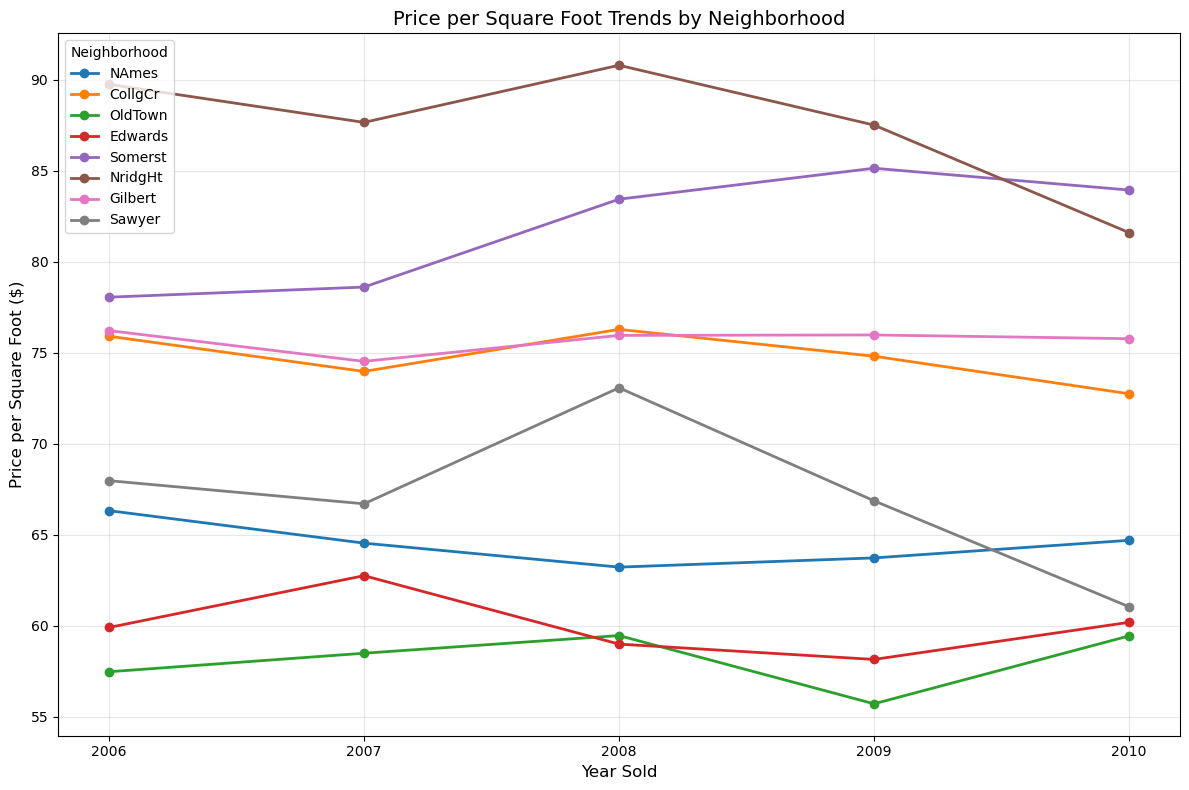

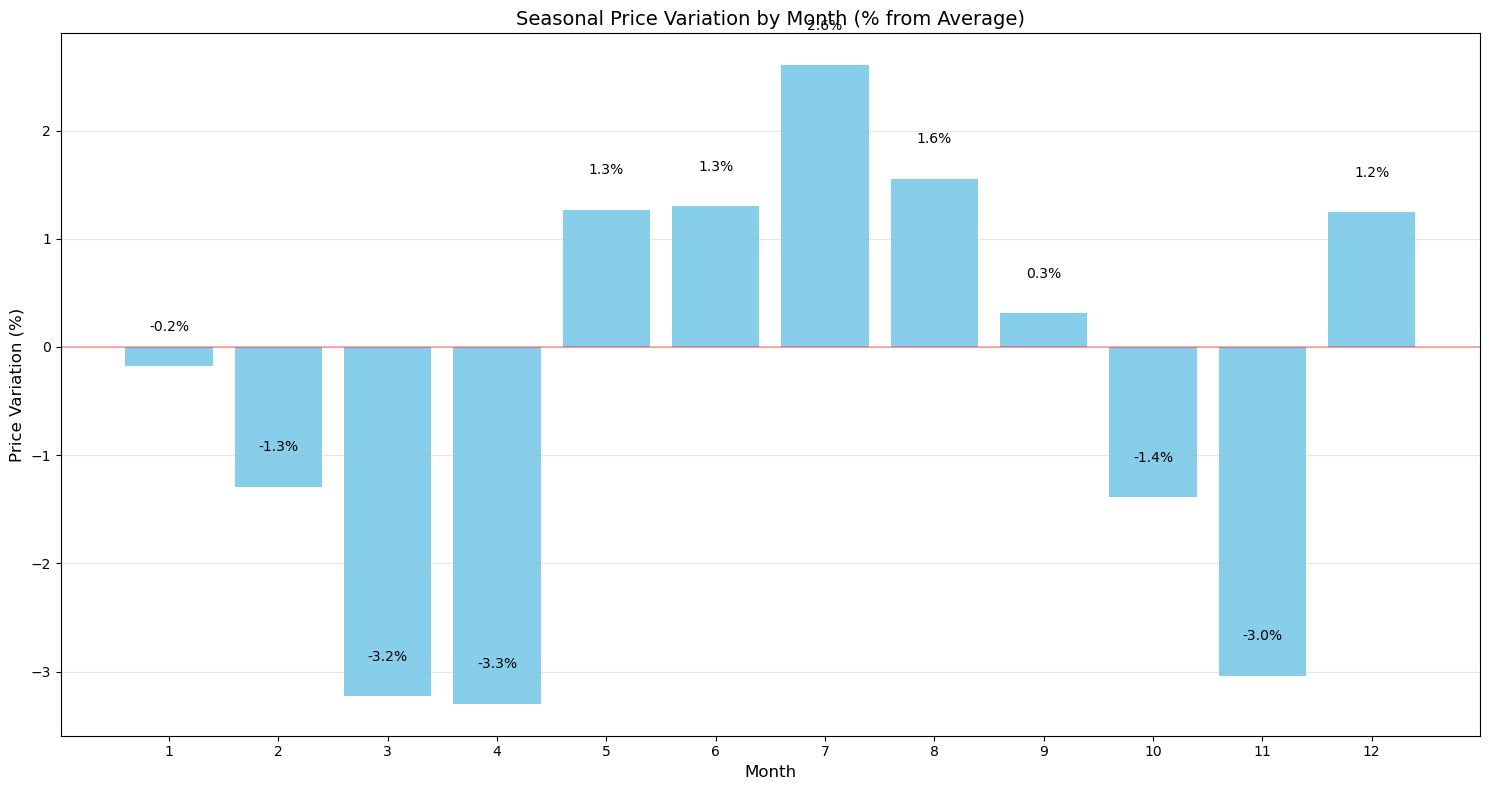

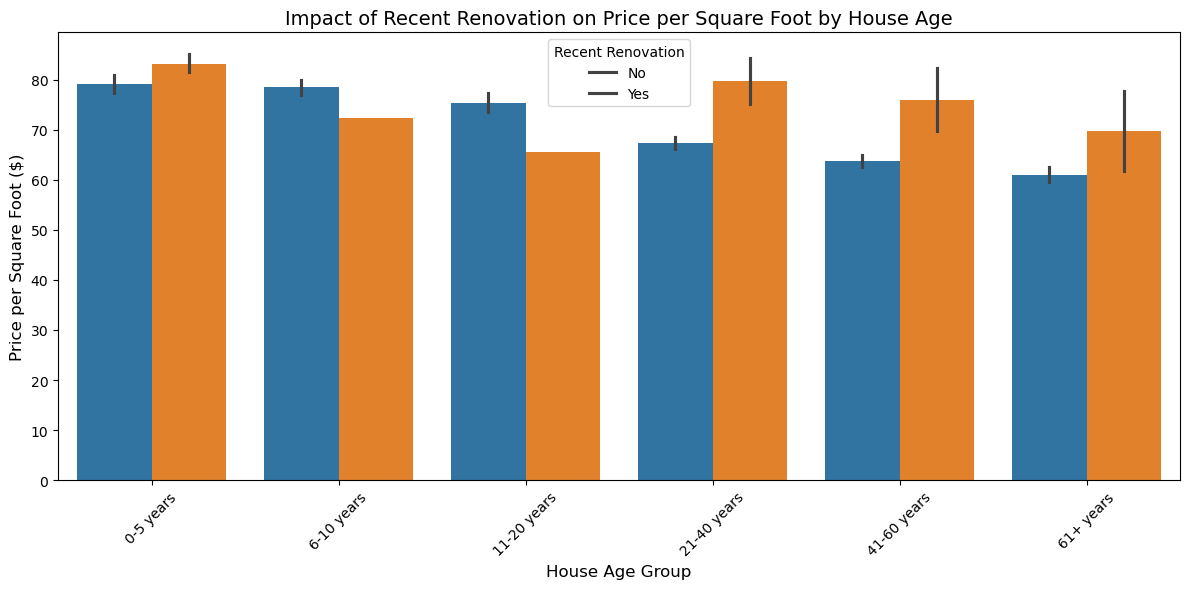

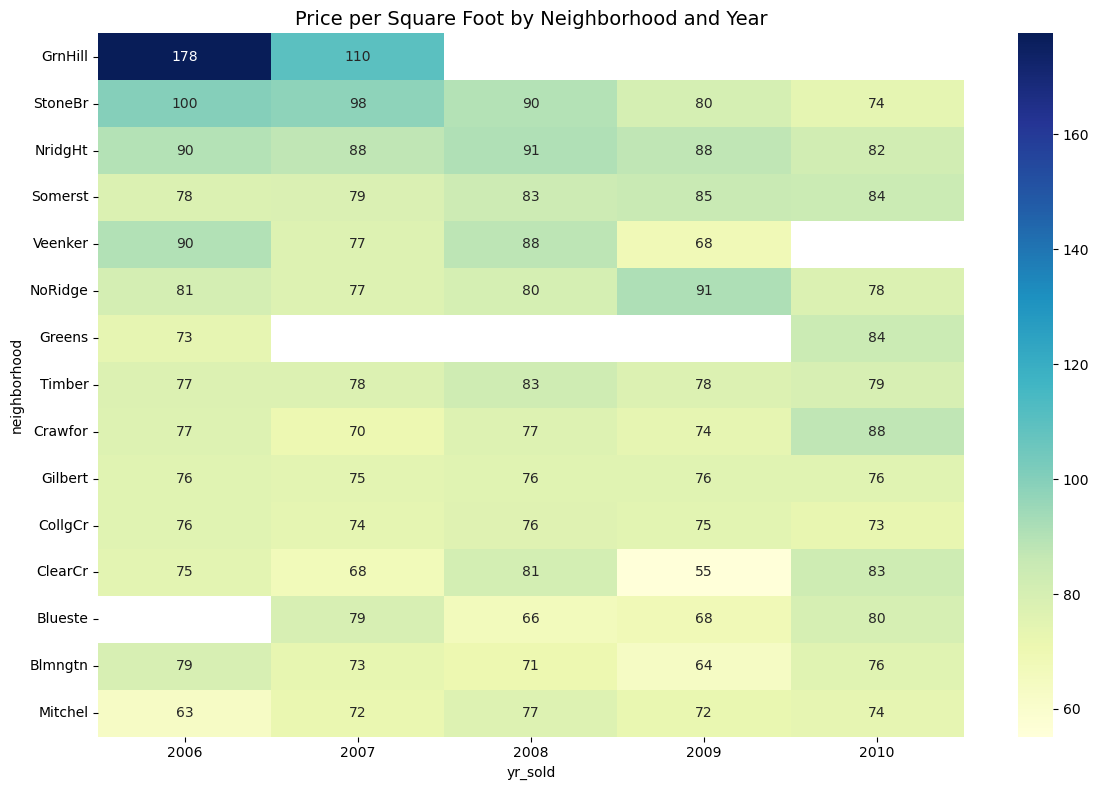

In [16]:
# Visualize the trends
visualize_price_trends(train_processed_enhanced)

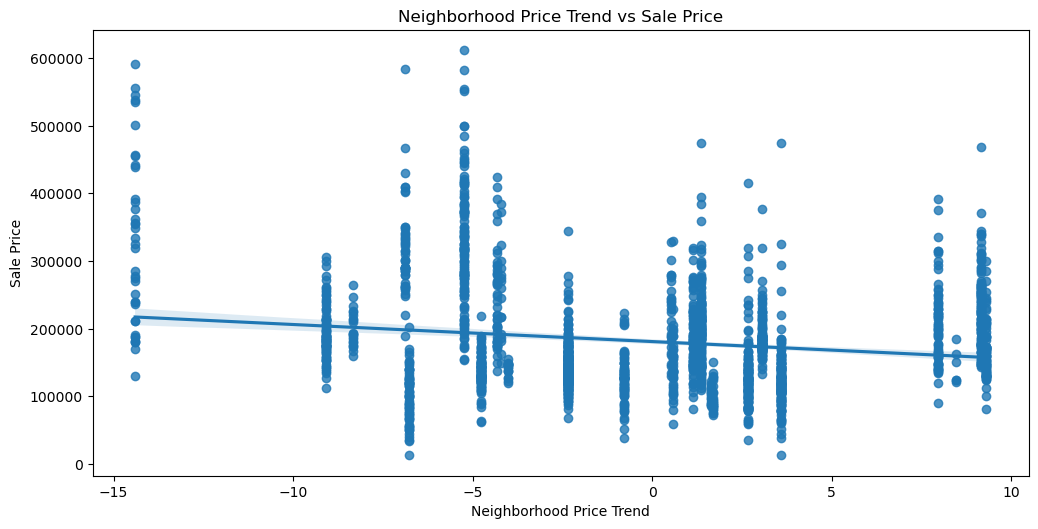

In [17]:
# Visualize relationship between log-transformed features and price
plt.figure(figsize=(20, 10))

plt.subplot(2,2,1)
sns.regplot(x='neighborhood_price_trend', y='saleprice', data=train_processed_enhanced)
plt.title('Neighborhood Price Trend vs Sale Price')
plt.xlabel('Neighborhood Price Trend')
plt.ylabel('Sale Price')

# plt.subplot(2,2,2)
# sns.regplot(x='living_area_qual', y='saleprice', data=train_processed)
# plt.title('Living Area Quality vs Sale Price')
# plt.xlabel('Living Area Quality')
# plt.ylabel('Sale Price')

plt.tight_layout()
plt.show()

### The selection criteria
1. Correlation with price - Features with the strongest relationship with the target variable
2. Low multicollinearity - VIF (Variance Inflation Factor) analysis showed acceptable levels for these features
3. Domain knowledge - Features that real estate experts know drive value
4. Transformed relationships - Features engineered to better capture non-linear effects
5. Dimensionality reduction - Combined features that reduced the model's complexity

This feature set balances the need for a comprehensive model with the principle of parsimony. Each feature provides unique information about property value, and together they capture the most important factors that determine home prices in Ames.

## 2. Final Feature List

In [18]:
# Define final features list
final_features = [
    # Top Priority Features
    'overall_qual', 'overall_qual2', 'log_gr_liv_area', 'total_sf', 'log_total_sf', 
    'neighborhood_price_level', 'kitchen_qual_num', 'year_built', 'house_age',
    
    # High-Value Features
    'total_bathrooms', 'garage_cars', 'exter_qual_num', 'bsmt_qual_num',
    'living_area_qual', 'log_lot_area',
    
    # Additional Value Features
    'remod_age', 'has_fireplace', 'bsmtfin_sf_1', 'qual_cond', 
    
    # Final Recommendations
    'central_air_num', 'mas_vnr_area', 'total_porch_sf'
]

# Add neighborhood as categorical feature
cat_features = ['neighborhood']
all_features = final_features + cat_features

# Check which features exist in the dataset
available_features = []
for feature in final_features:
    if feature in train_processed_enhanced.columns:
        available_features.append(feature)
    else:
        print(f"Warning: Feature '{feature}' not found in dataset. Checking for alternatives...")
        # Try to find close matches (e.g., with/without spaces)
        possible_match = feature.replace(' ', '')
        if possible_match in train_processed_enhanced.columns:
            available_features.append(possible_match)
            print(f"  - Found alternative: '{possible_match}'")
        else:
            print(f"  - No alternative found. This feature will be excluded.")

# Update all_features with only available features
all_features = available_features + cat_features
print(f"Final feature list ({len(all_features)} features):")
for feature in all_features:
    print(f"  - {feature}")

Final feature list (23 features):
  - overall_qual
  - overall_qual2
  - log_gr_liv_area
  - total_sf
  - log_total_sf
  - neighborhood_price_level
  - kitchen_qual_num
  - year_built
  - house_age
  - total_bathrooms
  - garage_cars
  - exter_qual_num
  - bsmt_qual_num
  - living_area_qual
  - log_lot_area
  - remod_age
  - has_fireplace
  - bsmtfin_sf_1
  - qual_cond
  - central_air_num
  - mas_vnr_area
  - total_porch_sf
  - neighborhood


## 3. Preparing Dataset for modeling

In [19]:
# Prepare final datasets for modeling
X_train = train_processed_enhanced[all_features]
y_train = train_processed_enhanced['saleprice']
X_test = test_processed_enhanced[all_features]

# Handle any remaining missing values
numeric_features = [f for f in available_features if f not in cat_features]
X_train[numeric_features] = X_train[numeric_features].fillna(X_train[numeric_features].median())
X_test[numeric_features] = X_test[numeric_features].fillna(X_train[numeric_features].median())

for cat in cat_features:
    X_train[cat] = X_train[cat].fillna(X_train[cat].mode()[0])
    X_test[cat] = X_test[cat].fillna(X_train[cat].mode()[0])

# Check for any remaining missing values
print("Any missing values in X_train?", X_train.isnull().any().any())
print("Any missing values in X_test?", X_test.isnull().any().any())

Any missing values in X_train? False
Any missing values in X_test? False


In [20]:
# Save processed data for modeling in the next notebook
# Create a dictionary with all the important variables
processed_data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'test_ID': test_ID,
    'numeric_features': numeric_features,
    'categorical_features': cat_features
}

print("Saving the following:")
print(f"- X_train shape: {X_train.shape}")
print(f"- X_test shape: {X_test.shape}")
print(f"- numeric_features: {len(numeric_features)} features")
print(f"- categorical_features: {len(cat_features)} features")

# Save as pickle file
import pickle
with open('../data/processed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("Processed data saved for modeling!")

Saving the following:
- X_train shape: (2051, 23)
- X_test shape: (878, 23)
- numeric_features: 22 features
- categorical_features: 1 features
Processed data saved for modeling!


In [21]:
def visualize_price_trends(train_df, neighborhoods=None, num_top_neighborhoods=8):
    """
    Create visualizations of price per square foot trends
    
    Parameters:
    -----------
    train_df : DataFrame
        DataFrame containing housing data
    neighborhoods : list, optional
        List of specific neighborhoods to visualize. If None, top neighborhoods by count are used.
    num_top_neighborhoods : int, optional
        Number of top neighborhoods to display if specific neighborhoods aren't provided
    """
    # Make sure individual_price_per_sf is calculated
    if 'individual_price_per_sf' not in train_df.columns:
        train_df['individual_price_per_sf'] = train_df['saleprice'] / train_df['total_sf']
    
    # Calculate median price per sf by year and neighborhood
    price_trends = train_df.groupby(['neighborhood', 'yr_sold'])['individual_price_per_sf'].median().reset_index()
    
    # Determine which neighborhoods to display
    if neighborhoods is None:
        # Use top neighborhoods by count
        selected_neighborhoods = train_df['neighborhood'].value_counts().head(num_top_neighborhoods).index.tolist()
        title_prefix = f"Top {num_top_neighborhoods}"
    else:
        # Use the provided list of neighborhoods
        selected_neighborhoods = neighborhoods
        title_prefix = "Selected"
    
    # Check if any specified neighborhoods are not in the data
    all_neighborhoods = train_df['neighborhood'].unique()
    invalid_neighborhoods = [n for n in selected_neighborhoods if n not in all_neighborhoods]
    if invalid_neighborhoods:
        print(f"Warning: These neighborhoods are not in the dataset: {', '.join(invalid_neighborhoods)}")
        selected_neighborhoods = [n for n in selected_neighborhoods if n in all_neighborhoods]
    
    # Create a colormap for better distinction between lines
    #colors = plt.cm.viridis(np.linspace(0, 1, len(selected_neighborhoods)))
    
    # Plot price trends over time
    plt.figure(figsize=(14, 10))
    
    for i, neighborhood in enumerate(selected_neighborhoods):
        subset = price_trends[price_trends['neighborhood'] == neighborhood]
        if not subset.empty:
            plt.plot(subset['yr_sold'], 
                     subset['individual_price_per_sf'], 
                     marker='o', 
                     linewidth=2.5, 
                     label=neighborhood,
                     #color=colors[i],
                     markersize=8)
    
    # Improve the title and axis labels
    plt.title(f'Price per Square Foot Trends for {title_prefix} Neighborhoods', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year Sold', fontsize=14, labelpad=10)
    plt.ylabel('Price per Square Foot ($)', fontsize=14, labelpad=10)
    
    # Enhance the legend
    plt.legend(title='Neighborhood', title_fontsize=12, 
               fontsize=11, bbox_to_anchor=(1.02, 1), 
               loc='upper left', borderaxespad=0)
    
    # Improve grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Format x-axis ticks
    years = sorted(train_df['yr_sold'].unique())
    plt.xticks(years, fontsize=11)
    
    # Add annual overall market median as a reference line
    market_avg = train_df.groupby('yr_sold')['individual_price_per_sf'].median()
    plt.plot(market_avg.index, market_avg.values, 
             color='black', linestyle='--', linewidth=2.5, 
             label='Market Median', marker='s', markersize=8)
    
    # Add value annotations for market median
    for year, avg in market_avg.items():
        plt.annotate(f'${avg:.0f}', 
                    (year, avg),
                    textcoords="offset points",
                    xytext=(0,10), 
                    ha='center',
                    fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Add a note about the data
    plt.figtext(0.5, 0.01, 
               f"Analysis of {len(train_df)} properties. Market median shown as dashed black line.", 
               ha="center", fontsize=11, 
               bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    filename = '../images/neighborhood_price_trends'
    if neighborhoods is not None:
        filename += '_custom'
    plt.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a second visualization: heatmap of neighborhood price trends
    # Only include the selected neighborhoods in the heatmap
    pivot_data = train_df[train_df['neighborhood'].isin(selected_neighborhoods)].pivot_table(
        index='neighborhood', 
        columns='yr_sold',
        values='individual_price_per_sf',
        aggfunc='median'
    )
    
    # Sort neighborhoods by median price
    pivot_data['avg_price'] = pivot_data.median(axis=1)
    pivot_data = pivot_data.sort_values('avg_price', ascending=False)
    pivot_data = pivot_data.drop('avg_price', axis=1)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_data, annot=True, fmt=".0f", cmap="YlGnBu", 
                linewidths=0.5, cbar_kws={'label': 'Price per Square Foot ($)'})
    plt.title(f'Price per Square Foot by Neighborhood and Year ({title_prefix})', fontsize=16)
    plt.ylabel('Neighborhood', fontsize=12)
    plt.xlabel('Year Sold', fontsize=12)
    plt.tight_layout()
    filename = '../images/neighborhood_price_heatmap'
    if neighborhoods is not None:
        filename += '_custom'
    plt.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return the selected neighborhoods and their price trends
    return 
    

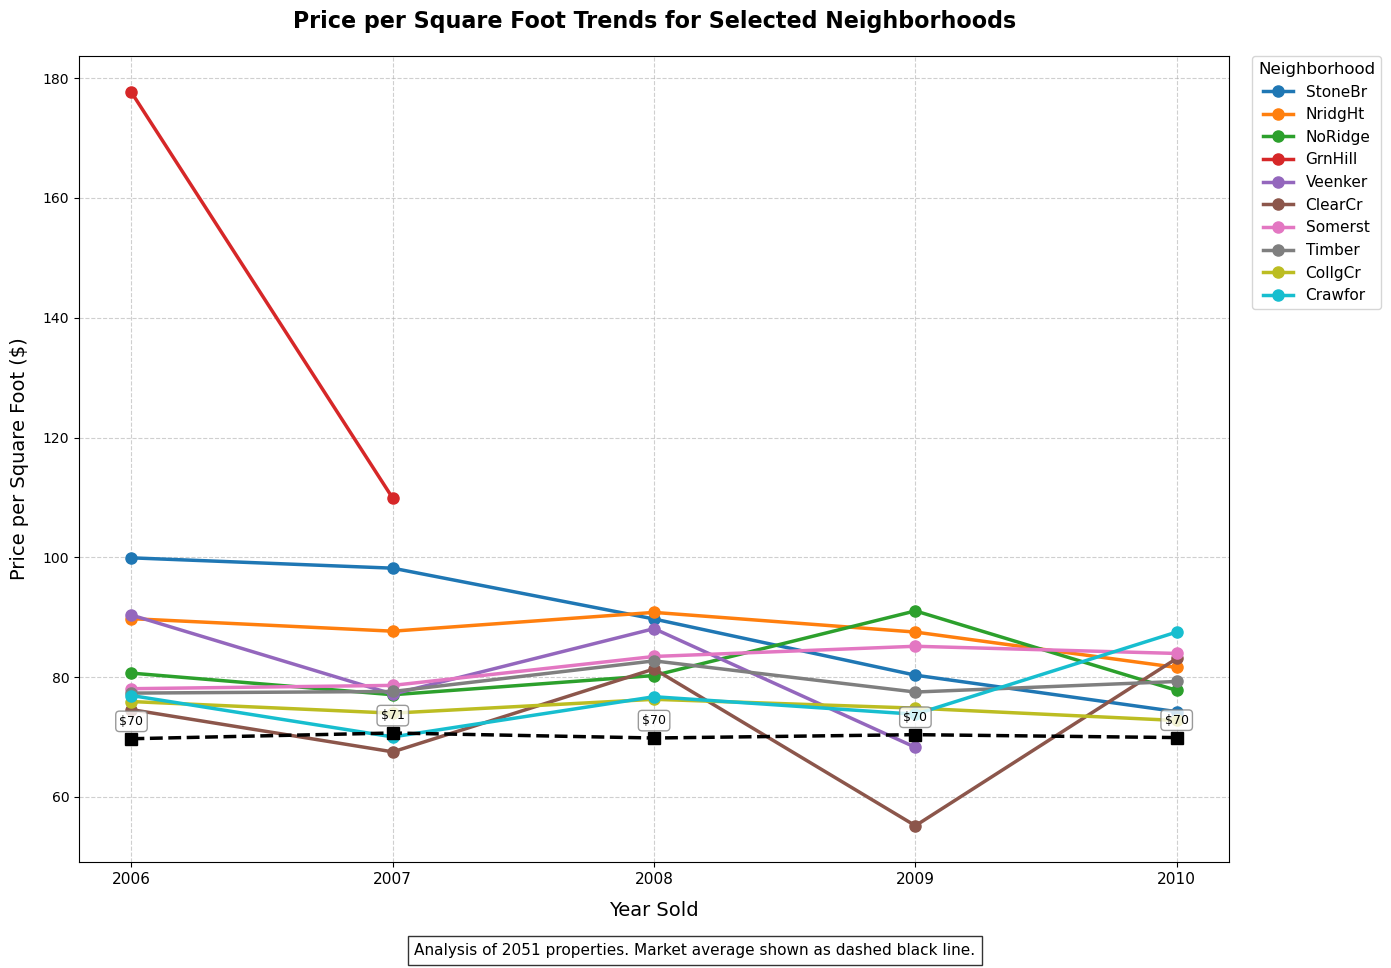

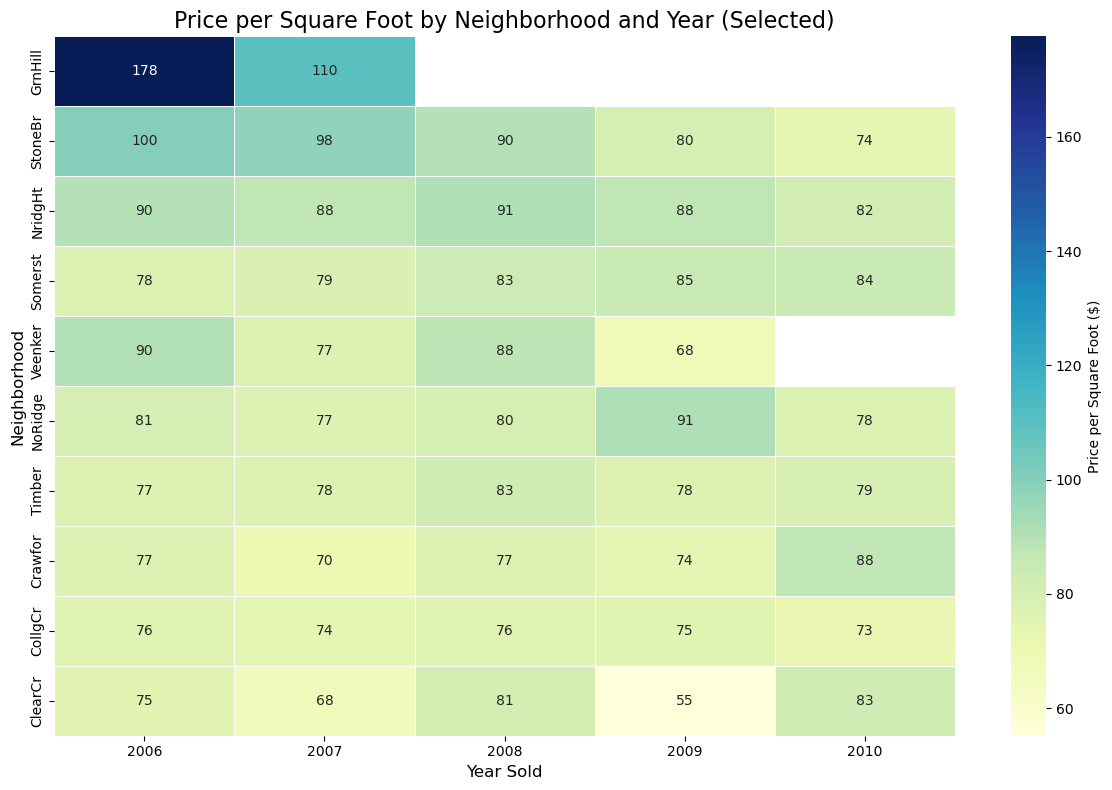

In [22]:
visualize_price_trends(train_processed_enhanced, neighborhoods=['StoneBr', 'NridgHt', 'NoRidge', 'GrnHill', 'Veenker', 'ClearCr', 'Somerst', 'Timber', 'CollgCr', 'Crawfor'])